# Processed Data Visualization Notebook

In [117]:
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## Open Processed Simulation Output

In [118]:
h5f = h5py.File("processed/proc_sims_v4.h5", "r")

## Data Structure

In [119]:
print("Top-Level:\n", list(h5f.keys()))
print("Header:\n", list(h5f["sims"]))
print("Header (sim<n>):\n", list(h5f["sims"]["sim0"]))

Top-Level:
 ['sims']
Header:
 ['sim0', 'sim1', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim2', 'sim3', 'sim4', 'sim5', 'sim6', 'sim7', 'sim8', 'sim9']
Header (sim<n>):
 ['alpha_zre', 'b0_zre', 'kb_zre', 'ksz_map', 'pk_tt', 'tau', 'xmval_list', 'zmean_zre', 'zval_list']


## Build DataFrame

In [120]:
rows = []
sims = h5f["sims"]

# Iterate through all sims in sims/
for name in sorted(sims.keys(), key=lambda s: int(s[3:]) if s.startswith("sim") and s[3:].isdigit() else s):
    g = sims[name]
    rows.append({
        "sim":          name,
        # Parameters
        "alpha_zre":    float(g["alpha_zre"][()]),
        "kb_zre":       float(g["kb_zre"][()]),
        "zmean_zre":    float(g["zmean_zre"][()]),
        "b0_zre":       float(g["b0_zre"][()]),
        "tau":          float(g["tau"][()]),
        # Info about per-sim grids
        "n_z":          int(g["zval_list"].shape[0]),
        "n_xm":         int(g["xmval_list"].shape[0]),
    })

df = pd.DataFrame(rows)
df.head()

,sim,alpha_zre,kb_zre,zmean_zre,b0_zre,tau,n_z,n_xm
0,sim0,0.123569,0.361813,8.026353,0.59312,0.061643,26,26
1,sim1,0.658593,1.319570,8.276313,0.59312,0.063533,26,26
2,sim2,0.569787,0.369425,8.481533,0.59312,0.064692,26,26
3,sim3,0.151896,1.349346,8.802202,0.59312,0.069649,26,26
4,sim4,0.194290,1.111912,7.723515,0.59312,0.058893,26,26


## Simulation Parameters
- **`alpha`** (0.10 - 0.90) : Controls how long reionization lasts.
- **`kb`** (0.10 - 2.0) : Determines how uneven the ionized regions are (higher values more clustered).
- **`zmean`** (7.0 - 9.0) : Sets the midpoint of reionization.
- **`b0`** (? - ?) : Adjusts the overall strength or amplitude of the ionization field.

### Summary

In [121]:
def summarize(col):
    s = df[col]
    return {"min": s.min(), "max": s.max(), "mean": s.mean(), "std": s.std(ddof=1), "n_unique": s.nunique()}

summary = pd.DataFrame({c: summarize(c) for c in ["alpha_zre","kb_zre","zmean_zre", "b0_zre"]}).T
summary


,min,max,mean,std,n_unique
alpha_zre,0.123569,0.892581,0.411444,2.247328e-01,19.0
kb_zre,0.164918,1.976855,1.192090,5.996471e-01,19.0
zmean_zre,7.034849,8.802202,8.042105,5.063991e-01,19.0
b0_zre,0.593120,0.593120,0.593120,1.140646e-16,1.0


### Histogram of Parameter Space
- Histograms should be flat for uniform coverage.

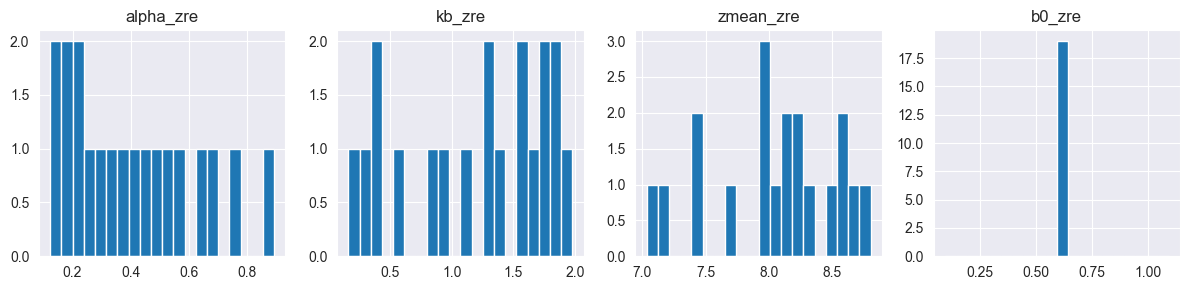

In [122]:
plt.figure(figsize=(12,3))
for i, col in enumerate(["alpha_zre","kb_zre","zmean_zre", "b0_zre"], 1):
    plt.subplot(1,4,i)
    plt.hist(df[col], bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.show()


## Spearman Correlation (Independence)

In [123]:
df[["alpha_zre","kb_zre","zmean_zre"]].corr(method="spearman")


,alpha_zre,kb_zre,zmean_zre
alpha_zre,1.000000,-0.219298,-0.203509
kb_zre,-0.219298,1.000000,0.100000
zmean_zre,-0.203509,0.100000,1.000000


## Coverage of Parameter Space

In [124]:
X = df[["alpha_zre","kb_zre","zmean_zre"]].to_numpy()
# Normalize to [0,1]
Xn = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
D = pdist(Xn)

print(f"Min Pairwise Distance: {np.min(D):.3f}")
print(f"Median Pairwise Distance: {np.median(D):.3f}")


Min Pairwise Distance: 0.077
Median Pairwise Distance: 0.707


## Close Files

In [125]:
h5f.close()